In [39]:
# pip install numpy
# pip install pandas
# pip install matplotlib
# pip install seaborn
# pip install joblib
# pip install xgboost

In [1]:
# import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import category_encoders as ce

In [2]:
# load data from the directory: C:\Users\stach\Documents\visual studio code\Heroku\titanic\
data = pd.read_csv(r'titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.shape

(891, 12)

<Axes: title={'center': 'Death status after Titanic crash'}, xlabel='Survived'>

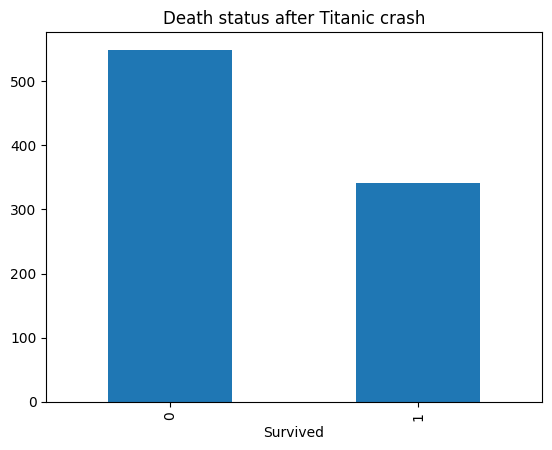

In [4]:
# let's explore the target
data['Survived'].value_counts().plot(kind='bar', title='Death status after Titanic crash', )

1. Variable types

In [5]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# Drop columns that are irrelevant for the ML model
data.drop(columns=['PassengerId', 'Name', 'Ticket'], axis=0, inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Actually, Pclass is not an integer because it stands for Passenger's class and indicates the standing of the ticket 

In [7]:
cat_vars = [var for var in data.columns if data[var].dtype=='O']
cat_vars = cat_vars + ['Pclass']
num_vars =[var for var in data.columns if var not in cat_vars and var !='Survived']
print(cat_vars)
num_vars


['Sex', 'Cabin', 'Embarked', 'Pclass']


['Age', 'SibSp', 'Parch', 'Fare']

2. Missing Data

In [8]:
# missing data
vars_with_na = [var for var in data.columns if data[var].isnull().sum()>0]
vars_with_na

['Age', 'Cabin', 'Embarked']

In [9]:
# Percentage of missing data, by descending order
data[vars_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

More than 77% of missing data for variable Cabin. It should be better to keep it out of our model

Embarked is a categorical variable with very low rate of missing data. we will use the mode as imputation method

Let's explore relationship between Age and the target Survived.

In [10]:
# First data imputation
cat_vars = [var for var in cat_vars if var !='Cabin']
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Embarked'].isnull().sum()

0

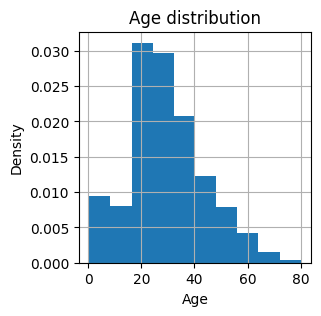

In [11]:
# Age distribution
data['Age'].hist(bins=10, density=True, figsize=(3, 3))
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

Age distribution is right-skewed. We should use median as imputation method for missing values.

Then, find a transformation that we provide a gaussian curve for  Age distribution

In [12]:
from math import floor
data['Age'].fillna(floor(data['Age'].median()), inplace=True)
data['Age'].isnull().sum()

0

In [13]:
# Make a boxplot for Age by the target
tmp = data.groupby('Survived')['Age'].mean()
tmp

Survived
0    30.028233
1    28.291433
Name: Age, dtype: float64

<Axes: xlabel='Survived'>

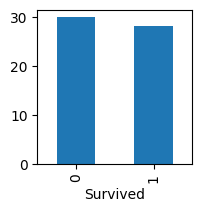

In [14]:
tmp.plot(kind='bar', figsize=(2,2))

People who survived after Titanic chrash tend to have the same range of age with those who died.

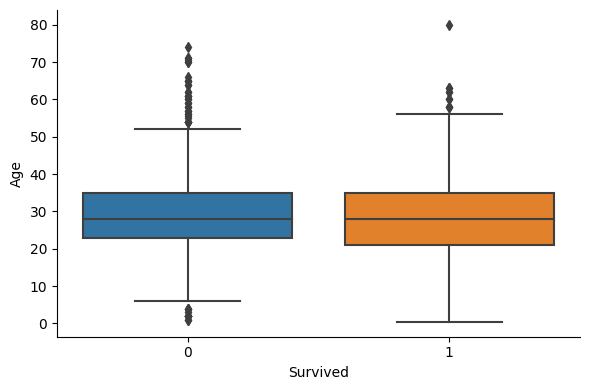

In [15]:
sns.catplot(y='Age', x='Survived', data=data, kind='box', height=4, aspect=1.5)

3. outliers

In [16]:
num_vars

['Age', 'SibSp', 'Parch', 'Fare']

Z-score imputation method is not recommended because Age distribution doesnt look gaussian.

https://www.analyticsvidhya.com/blog/2022/08/dealing-with-outliers-using-the-z-score-method/

To detect outliers for Age, it is recommended to use Inter Quartile Range (IQR) method.

lower_bound = Q1 - 1.5*Iq ; 

upper_bound = Q3 + 1.5*Iq

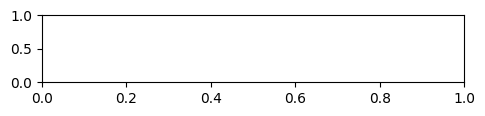

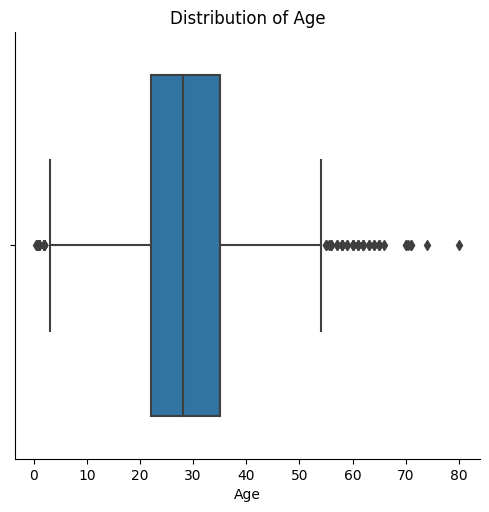

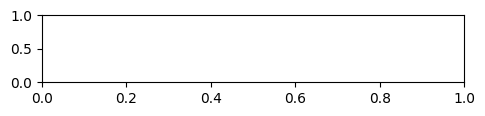

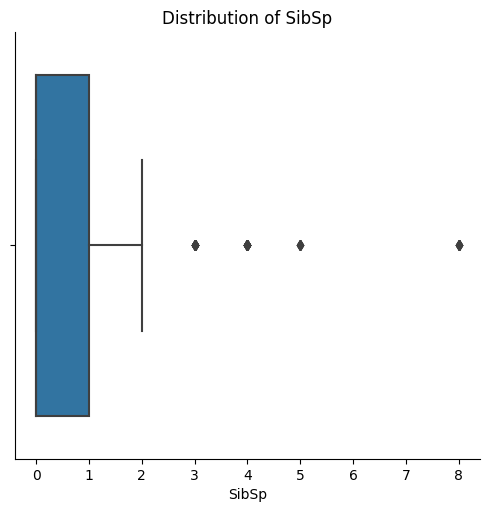

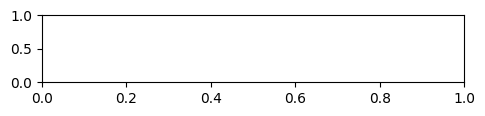

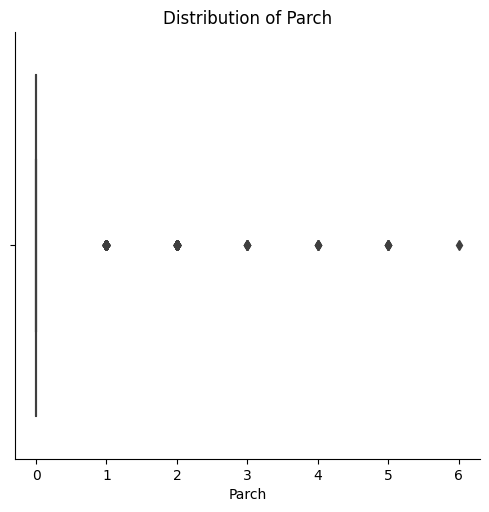

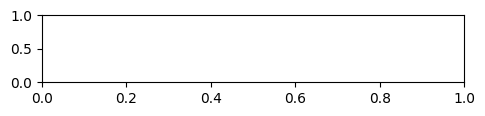

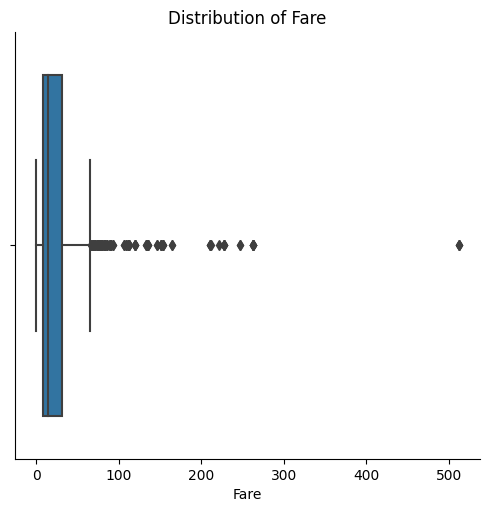

In [17]:
# Let's visualize IQR for each numerical variable
for var in num_vars:
    plt.figure(figsize=(12, 4))
    plt.subplot(4, 2, 2)
    sns.catplot(x=var, data=data, kind='box')
    plt.title('Distribution of ' + var)

Variables Fare an Age got some outliers that should be explored 

In [61]:
# Filter passenger with more than 70 age old
data_age_outliers = data[data['Age']>70]
data_age_outliers

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
96,0,1,male,71.0,0,0,34.6542,A5,C
116,0,3,male,70.5,0,0,7.7500,NaN,Q
493,0,1,male,71.0,0,0,49.5042,NaN,C
630,1,1,male,80.0,0,0,30.0000,A23,S
851,0,3,male,74.0,0,0,7.7750,NaN,S


In [63]:
# Filter passenger who bought a ticket at more than 200US
data_fare_outliers = data[data['Fare']>200]
data_fare_outliers

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
27,0,1,male,19.0,3,2,263.0000,C23 C25 C27,S
88,1,1,female,23.0,3,2,263.0000,C23 C25 C27,S
118,0,1,male,24.0,0,1,247.5208,B58 B60,C
258,1,1,female,35.0,0,0,512.3292,NaN,C
299,1,1,female,50.0,0,1,247.5208,B58 B60,C
311,1,1,female,18.0,2,2,262.3750,B57 B59 B63 B66,C
341,1,1,female,24.0,3,2,263.0000,C23 C25 C27,S
377,0,1,male,27.0,0,2,211.5000,C82,C
380,1,1,female,42.0,0,0,227.5250,NaN,C
438,0,1,male,64.0,1,4,263.0000,C23 C25 C27,S


In [18]:
# Outiliers using with the IQR method

def outliers_dataframe (df, feature):
    copy_df = df.copy()
    # first and third quantiles
    q1 = np.quantile(copy_df[feature], 0.25)
    q3 = np.quantile(copy_df[feature], 0.75)

    # limits for good data points
    lower_bound = q1 - 1.5*(q3 - q1)
    upper_bound = q3 + 1.5*(q3 - q1)

        
    return copy_df[(copy_df[feature]<lower_bound) | (copy_df[feature]>upper_bound)]

You can explore outliers dataframe foe each numerical variable and analyze them separately

Sometime it is good to build ML model for customer recommendation

However for our initial model, it is highly recommended to replace outliers with lower and upper bound

In [19]:
outliers_age = outliers_dataframe(data, 'Age')
outliers_age

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
7,0,3,male,2.00,3,1,21.0750,NaN,S
11,1,1,female,58.00,0,0,26.5500,C103,S
15,1,2,female,55.00,0,0,16.0000,NaN,S
16,0,3,male,2.00,4,1,29.1250,NaN,Q
33,0,2,male,66.00,0,0,10.5000,NaN,S
...,...,...,...,...,...,...,...,...,...
827,1,2,male,1.00,0,2,37.0042,NaN,C
829,1,1,female,62.00,0,0,80.0000,B28,S
831,1,2,male,0.83,1,1,18.7500,NaN,S
851,0,3,male,74.00,0,0,7.7750,NaN,S


In [111]:
for var in num_vars:
    print('outliers_'+var)
    print(outliers_dataframe(data, var))

outliers_Age
     Survived  Pclass     Sex    Age  SibSp  Parch     Fare Cabin Embarked
7           0       3    male   2.00      3      1  21.0750   NaN        S
11          1       1  female  58.00      0      0  26.5500  C103        S
15          1       2  female  55.00      0      0  16.0000   NaN        S
16          0       3    male   2.00      4      1  29.1250   NaN        Q
33          0       2    male  66.00      0      0  10.5000   NaN        S
..        ...     ...     ...    ...    ...    ...      ...   ...      ...
827         1       2    male   1.00      0      2  37.0042   NaN        C
829         1       1  female  62.00      0      0  80.0000   B28        S
831         1       2    male   0.83      1      1  18.7500   NaN        S
851         0       3    male  74.00      0      0   7.7750   NaN        S
879         1       1  female  56.00      0      1  83.1583   C50        C

[66 rows x 9 columns]
outliers_SibSp
     Survived  Pclass     Sex   Age  SibSp  Parch

In [23]:
# Replace outliers with lower or upper bound

def imput_outliers (df, features_list):
    for var in features_list:
        # quantiles
        q1 = np.quantile(df[var], 0.25)
        q3 = np.quantile(df[var], 0.75)

        # limits for good data points
        lower_bound = q1 - 1.5*(q3 - q1)
        upper_bound = q3 + 1.5*(q3 - q1)

        # Imputation
        df.loc[df[var]<lower_bound, var] = lower_bound
        df.loc[df[var]>upper_bound, var] = upper_bound

    

In [24]:
data.loc[data['Age']<25]['Age']

0      22.0
7       2.0
9      14.0
10      4.0
12     20.0
       ... 
875    15.0
876    20.0
877    19.0
882    22.0
887    19.0
Name: Age, Length: 278, dtype: float64

In [26]:
data_without_outliers = data.copy()
imput_outliers(data_without_outliers, num_vars)
data_without_outliers

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1.0,0,7.2500,NaN,S
1,1,1,female,38.0,1.0,0,65.6344,C85,C
2,1,3,female,26.0,0.0,0,7.9250,NaN,S
3,1,1,female,35.0,1.0,0,53.1000,C123,S
4,0,3,male,35.0,0.0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0.0,0,13.0000,NaN,S
887,1,1,female,19.0,0.0,0,30.0000,B42,S
888,0,3,female,28.0,1.0,0,23.4500,NaN,S
889,1,1,male,26.0,0.0,0,30.0000,C148,C


In [27]:
(data_without_outliers==data).isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

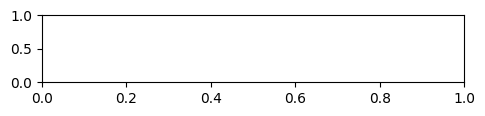

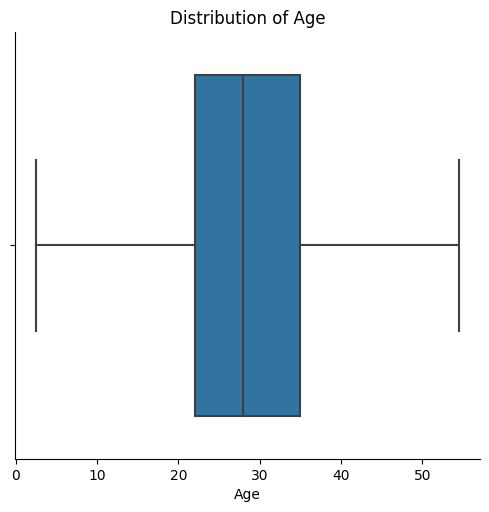

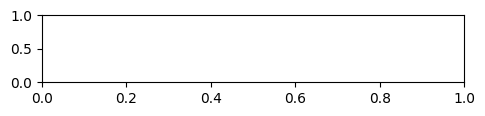

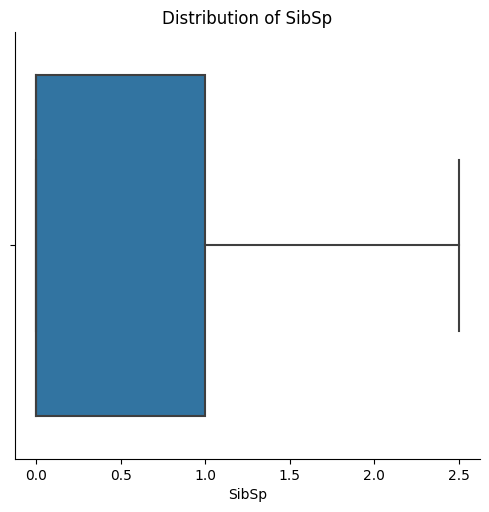

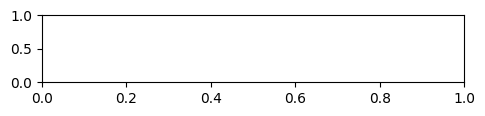

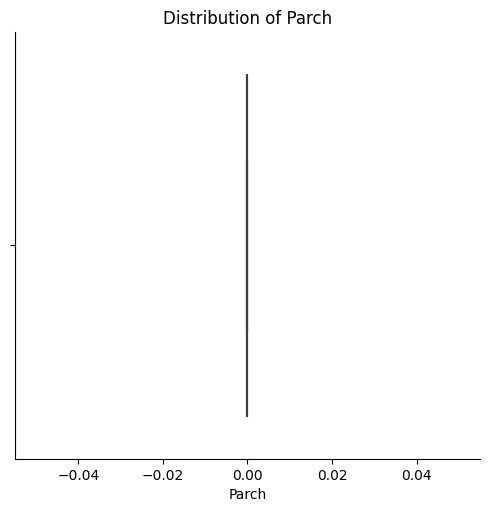

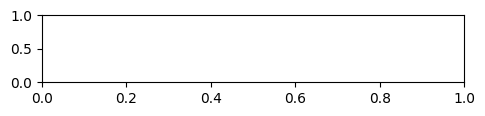

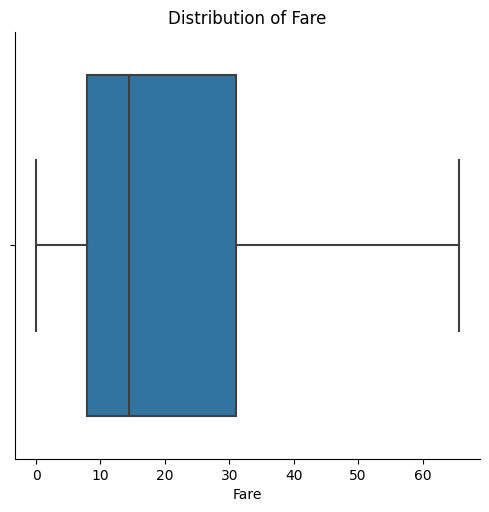

In [28]:
# Let's make some verification with boxplot
for var in num_vars:
    plt.figure(figsize=(12, 4))
    plt.subplot(4, 2, 2)
    sns.catplot(x=var, data=data_without_outliers, kind='box')
    plt.title('Distribution of ' + var)

In [29]:
cat_vars

['Sex', 'Embarked', 'Pclass']

In [30]:
num_vars

['Age', 'SibSp', 'Parch', 'Fare']

4. Data transformation

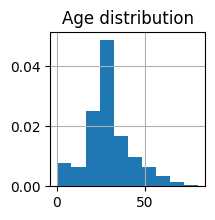

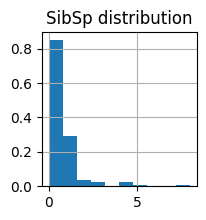

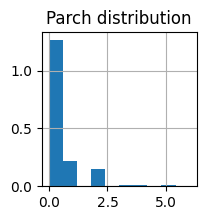

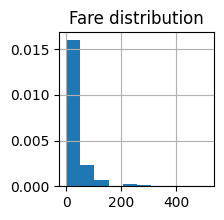

In [31]:
# Histogram for numerical variables
for var in num_vars:
    plt.figure(figsize=(2, 2))
    data[var].hist(density=True)
    plt.title(var +' distribution')
    plt.show()

<Axes: >

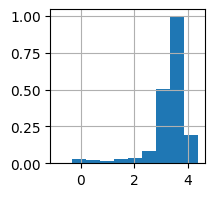

In [32]:
# Age is right-skewed. Apply log transformation
plt.figure(figsize=(2, 2))
np.log(data['Age']).hist(density=True)

array([[<Axes: title={'center': '0'}>]], dtype=object)

<Figure size 200x200 with 0 Axes>

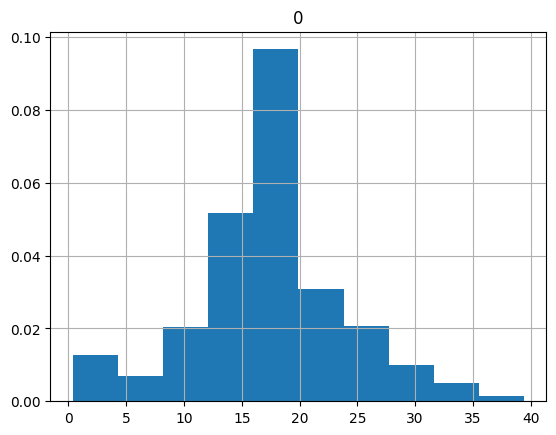

In [34]:
# Age is right-skewed. Apply Yeo-Johnson transformation
yeo_age, param = stats.yeojohnson(data['Age'])
plt.figure(figsize=(2, 2))
pd.DataFrame(yeo_age).hist(density=True)

Finally, none of those transformation was relevant